# Cryptocurrency Prediction

## 1. Prepare Data Set<a id="1"></a>

In [1]:
import numpy as np
import pandas as pd
import datetime as dt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style("whitegrid")
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge, ElasticNetCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

### Load and Prepare Data Set<a id="1-2"></a>

In [2]:
# load data set
data = pd.read_csv('/Users/fayazmoqueem/Desktop/crypto-markets.csv', parse_dates=['date'],index_col='date')

In [3]:
# display appointment data set
data.head()

,slug,symbol,name,ranknow,open,high,low,close,volume,market,close_ratio,spread
date,,,,,,,,,,,,
2013-04-28,bitcoin,BTC,Bitcoin,1,135.30,135.98,132.10,134.21,0,1500520000,0.5438,3.88
2013-04-29,bitcoin,BTC,Bitcoin,1,134.44,147.49,134.00,144.54,0,1491160000,0.7813,13.49
2013-04-30,bitcoin,BTC,Bitcoin,1,144.00,146.93,134.05,139.00,0,1597780000,0.3843,12.88
2013-05-01,bitcoin,BTC,Bitcoin,1,139.00,139.89,107.72,116.99,0,1542820000,0.2882,32.17
2013-05-02,bitcoin,BTC,Bitcoin,1,116.38,125.60,92.28,105.21,0,1292190000,0.3881,33.32


In [4]:
data = data[data.symbol.isin(['BTC', 'LTC', 'ETH'])]

In [5]:

data.name.value_counts()

Bitcoin     1761
Litecoin    1761
Ethereum     930
Name: name, dtype: int64

In [6]:

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4452 entries, 2013-04-28 to 2018-02-21
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   slug         4452 non-null   object 
 1   symbol       4452 non-null   object 
 2   name         4452 non-null   object 
 3   ranknow      4452 non-null   int64  
 4   open         4452 non-null   float64
 5   high         4452 non-null   float64
 6   low          4452 non-null   float64
 7   close        4452 non-null   float64
 8   volume       4452 non-null   int64  
 9   market       4452 non-null   int64  
 10  close_ratio  4452 non-null   float64
 11  spread       4452 non-null   float64
dtypes: float64(6), int64(3), object(3)
memory usage: 452.2+ KB


## 2. Data Preprocessing<a id="2"></a>

### Check Missing Values<a id="2-1"></a>

In [7]:
# check if data set contains missing values
print(data.isnull().sum())

# assert that there are no missing values
assert data.notnull().all().all()

slug           0
symbol         0
name           0
ranknow        0
open           0
high           0
low            0
close          0
volume         0
market         0
close_ratio    0
spread         0
dtype: int64


No missing value exist in this data set.

### Check Duplicated Values<a id="2-2"></a>

In [8]:
# check if data set contains duplicated records
print(data.duplicated().sum())

0


There is no duplicated appointments record in this data set. The data is clean.

## 3. Exploratory Data Analysis and Feature Engineering<a id="3"></a>

### Market Capitalization and Transaction Volume<a id="3-1"></a>

Check market capitalization and transaction volume for each cryptocurrency we choose.

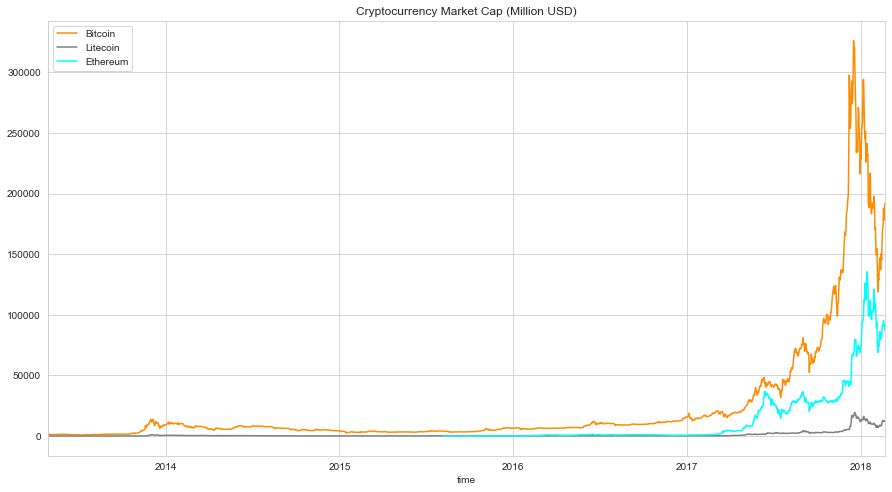

In [9]:
# plot market capitalization
bitcoin = data[data['symbol']=='BTC']
litecoin = data[data['symbol']=='LTC']

ethereum = data[data['symbol']=='ETH']


plt.figure(figsize=(15,8))
(bitcoin['market']/1000000).plot(color='darkorange', label='Bitcoin')
(litecoin['market']/1000000).plot(color='grey', label='Litecoin')

(ethereum['market']/1000000).plot(color='cyan', label='Ethereum')


plt.legend()
plt.xlabel('time')
plt.title('Cryptocurrency Market Cap (Million USD)')
plt.show()

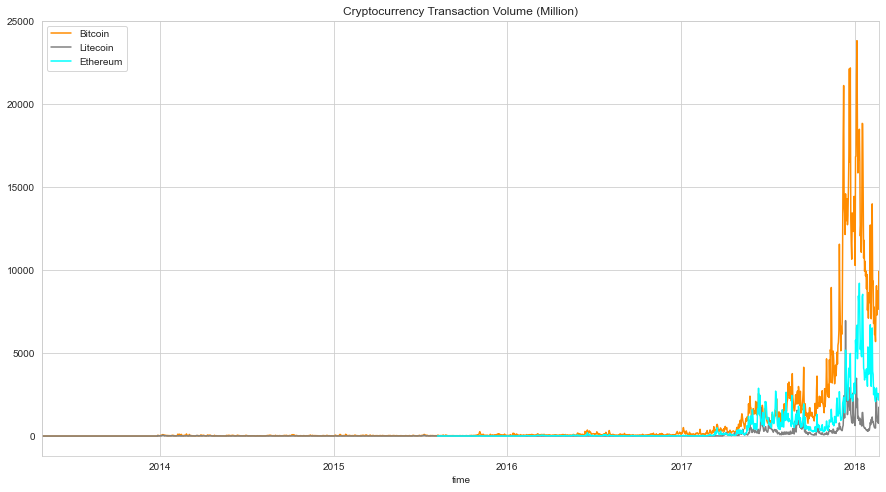

In [10]:
# plot transaction volume
plt.figure(figsize=(15,8))
(bitcoin['volume']/1000000).plot(color='darkorange', label='Bitcoin')
(litecoin['volume']/1000000).plot(color='grey', label='Litecoin')

(ethereum['volume']/1000000).plot(color='cyan', label='Ethereum')

plt.legend()
plt.xlabel('time')
plt.title('Cryptocurrency Transaction Volume (Million)')
plt.show()

In [11]:
data_m = data['2017-12-01':'2017-12-31']

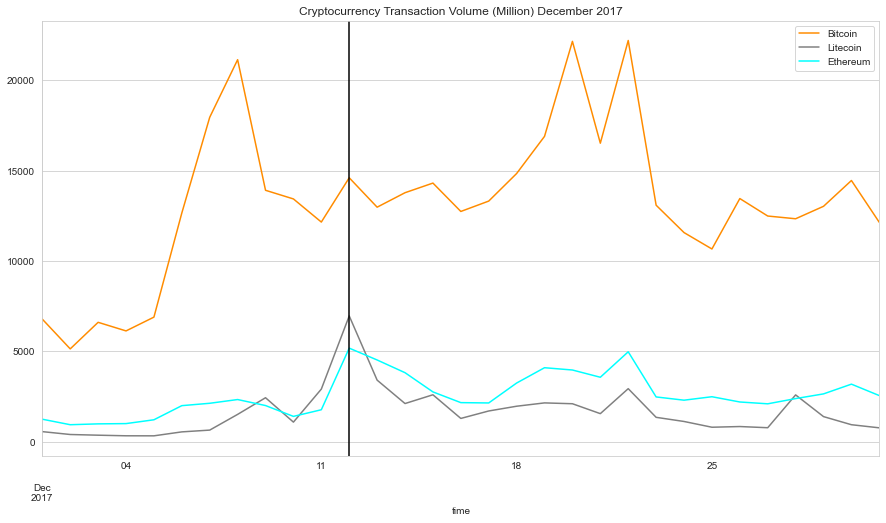

In [12]:
bitcoin = data_m[data_m['symbol']=='BTC']
litecoin = data_m[data_m['symbol']=='LTC']

ethereum = data_m[data_m['symbol']=='ETH']


plt.figure(figsize=(15,8))
(bitcoin['volume']/1000000).plot(color='darkorange', label='Bitcoin')
(litecoin['volume']/1000000).plot(color='grey', label='Litecoin')

(ethereum['volume']/1000000).plot(color='cyan', label='Ethereum')

plt.axvline(dt.datetime(2017, 12, 12),color='black')
plt.legend()
plt.xlabel('time')
plt.title('Cryptocurrency Transaction Volume (Million) December 2017')
plt.show()

In [13]:
data = data['2017-01-01':]
data.head()

,slug,symbol,name,ranknow,open,high,low,close,volume,market,close_ratio,spread
date,,,,,,,,,,,,
2017-01-01,bitcoin,BTC,Bitcoin,1,963.66,1003.08,958.70,998.33,147775000,15491200000,0.8930,44.38
2017-01-02,bitcoin,BTC,Bitcoin,1,998.62,1031.39,996.70,1021.75,222185000,16055100000,0.7221,34.69
2017-01-03,bitcoin,BTC,Bitcoin,1,1021.60,1044.08,1021.60,1043.84,185168000,16426600000,0.9893,22.48
2017-01-04,bitcoin,BTC,Bitcoin,1,1044.40,1159.42,1044.40,1154.73,344946000,16795400000,0.9592,115.02
2017-01-05,bitcoin,BTC,Bitcoin,1,1156.73,1191.10,910.42,1013.38,510199000,18604000000,0.3668,280.68


### Price Fluctuation of Cryptocurrencies<a id="3-2"></a>

Check opening, closing, highest, and lowest price for each of the cryptocurrency.

In [14]:
data['oc_diff']=data['close']-data['open']
data.head()

,slug,symbol,name,ranknow,open,high,low,close,volume,market,close_ratio,spread,oc_diff
date,,,,,,,,,,,,,
2017-01-01,bitcoin,BTC,Bitcoin,1,963.66,1003.08,958.70,998.33,147775000,15491200000,0.8930,44.38,34.67
2017-01-02,bitcoin,BTC,Bitcoin,1,998.62,1031.39,996.70,1021.75,222185000,16055100000,0.7221,34.69,23.13
2017-01-03,bitcoin,BTC,Bitcoin,1,1021.60,1044.08,1021.60,1043.84,185168000,16426600000,0.9893,22.48,22.24
2017-01-04,bitcoin,BTC,Bitcoin,1,1044.40,1159.42,1044.40,1154.73,344946000,16795400000,0.9592,115.02,110.33
2017-01-05,bitcoin,BTC,Bitcoin,1,1156.73,1191.10,910.42,1013.38,510199000,18604000000,0.3668,280.68,-143.35


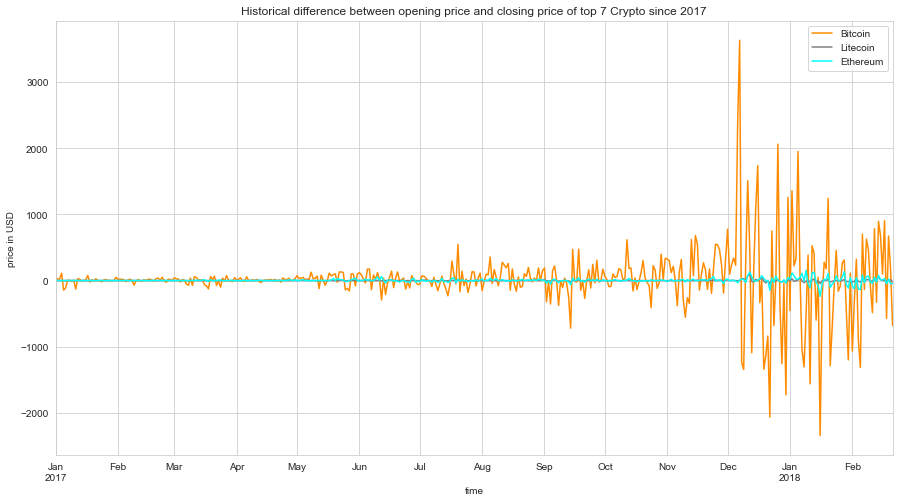

In [15]:
# Difference between opening and closing price
data['oc_diff']=data['close']-data['open']
bitcoin = data[data['symbol']=='BTC']
litecoin = data[data['symbol']=='LTC']

ethereum = data[data['symbol']=='ETH']


plt.figure(figsize=(15,8))
(bitcoin['oc_diff']).plot(color='darkorange', label='Bitcoin')
(litecoin['oc_diff']).plot(color='grey', label='Litecoin')

(ethereum['oc_diff']).plot(color='cyan', label='Ethereum')


plt.xlabel('time')
plt.ylabel('price in USD')
plt.title('Historical difference between opening price and closing price of top 7 Crypto since 2017')
plt.legend()
plt.show()

In [16]:
# Average difference for each cryptocurrency
ave_diff={'bitcoin':[(bitcoin['oc_diff']).mean()],
          'litecoin':[(litecoin['oc_diff']).mean()],
          'ethereum':[(ethereum['oc_diff']).mean()]}
pd.DataFrame(ave_diff, index=['avg.diff'])

,bitcoin,litecoin,ethereum
avg.diff,22.604724,0.450552,1.86199


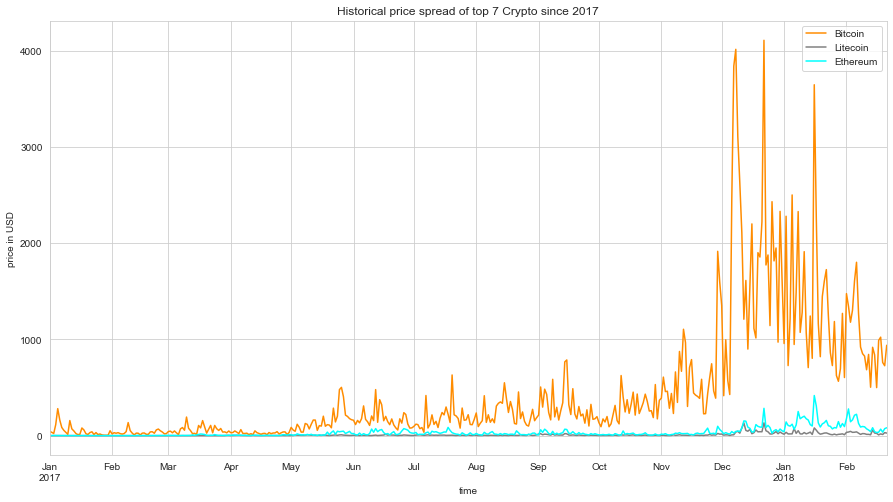

In [17]:
# Differences of daily highest price and lowest price
plt.figure(figsize=(15,8))
(bitcoin['spread']).plot(color='darkorange', label='Bitcoin')
(litecoin['spread']).plot(color='grey', label='Litecoin')
#(ripple['spread']).plot(color='blue', label='Ripple')
#(monero['spread']).plot(color='yellow', label='Monero')
(ethereum['spread']).plot(color='cyan', label='Ethereum')
#(zcash['spread']).plot(color='red', label='Zcash')
#(bitcoin_cash['spread']).plot(color='green', label='Bitcoin Cash')

plt.xlabel('time')
plt.ylabel('price in USD')
plt.title('Historical price spread of top 7 Crypto since 2017')
plt.legend()
plt.show()

In [18]:
# Average spread for each cryptocurrency
ave_spread={'bitcoin':[(bitcoin['spread']).mean()],
          'litecoin':[(litecoin['spread']).mean()],
          'ethereum':[(ethereum['spread']).mean()],}
pd.DataFrame(ave_spread, index=['avg.spread'])

,bitcoin,litecoin,ethereum
avg.spread,440.968441,8.522134,33.442902


### Moving Averages and Price Trend<a id="3-3"></a>

A moving average (MA) is a widely used indicator in technical analysis that helps smooth out price action by filtering out the “noise” from random price fluctuations. It is a trend-following, or lagging, indicator because it is based on past prices.

In [19]:
# calculate 5-day moving averages
btc = bitcoin[['close']]
btc.columns = ['BTC']
btc_ma=btc.rolling(window=5).mean()

ltc = litecoin[['close']]
ltc.columns = ['LTC']
ltc_ma=ltc.rolling(window=5).mean()



eth = ethereum[['close']]
eth.columns = ['ETH']
eth_ma=eth.rolling(window=5).mean()


# create matrix of close price only for later use
close = pd.concat([btc,ltc,eth], axis=1)
close_ma = pd.concat([btc_ma,ltc_ma,eth_ma], axis=1)
close_ma.tail()

,BTC,LTC,ETH
date,,,
2018-02-17,9921.188,211.586,924.826
2018-02-18,10311.886,222.824,940.558
2018-02-19,10658.020,224.764,944.620
2018-02-20,10905.480,226.248,936.298
2018-02-21,10996.780,222.894,917.450


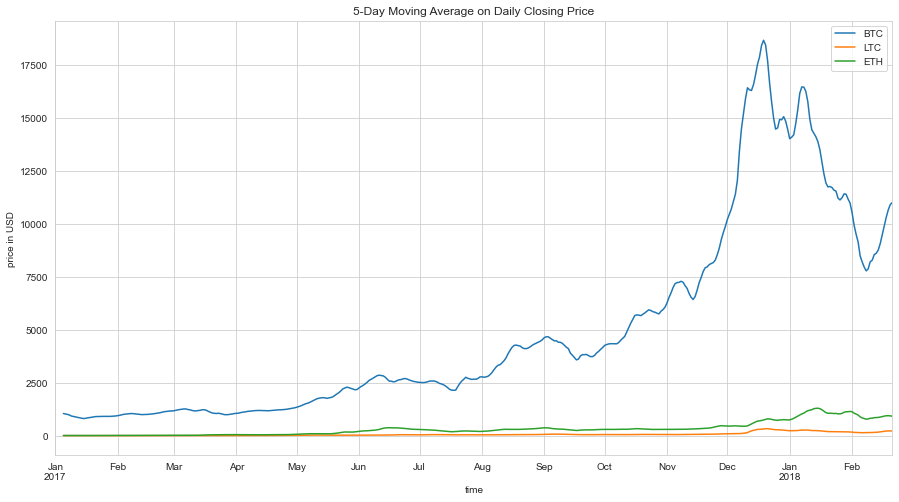

In [20]:
# plot moving average for closing price for cryptocurrencies
close_ma.plot(figsize=(15,8))
plt.title('5-Day Moving Average on Daily Closing Price')
plt.xlabel('time')
plt.ylabel('price in USD')
plt.show()

### Market Prices of Cryptocurrencies<a id="3-4"></a>

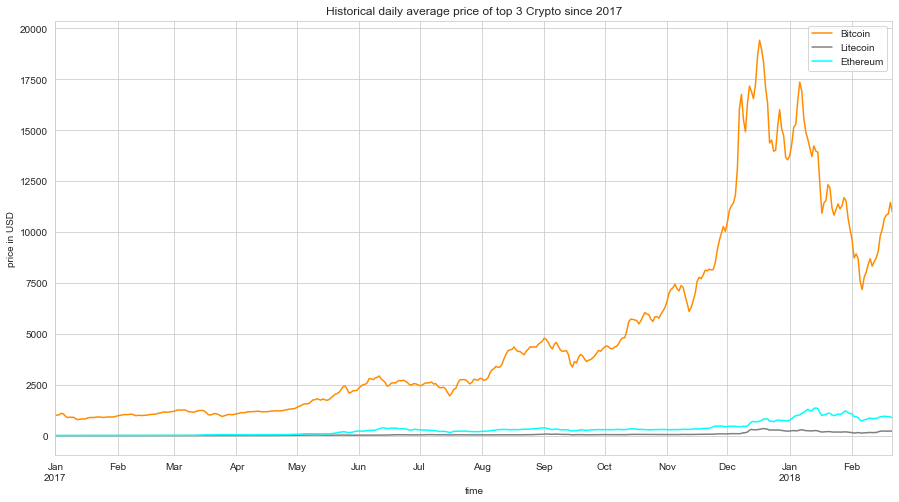

In [21]:
# calculate daily average price
data['daily_avg'] = (data['open'] + data['high'] + data['low'] + data['close']) / 4
bitcoin = data[data['symbol']=='BTC']
litecoin = data[data['symbol']=='LTC']

ethereum = data[data['symbol']=='ETH']


plt.figure(figsize=(15,8))
(bitcoin['daily_avg']).plot(color='darkorange', label='Bitcoin')
(litecoin['daily_avg']).plot(color='grey', label='Litecoin')

(ethereum['daily_avg']).plot(color='cyan', label='Ethereum')


plt.xlabel('time')
plt.ylabel('price in USD')
plt.title('Historical daily average price of top 3 Crypto since 2017')
plt.legend()
plt.show()

#### Plot individual daily open, high, low, close prices

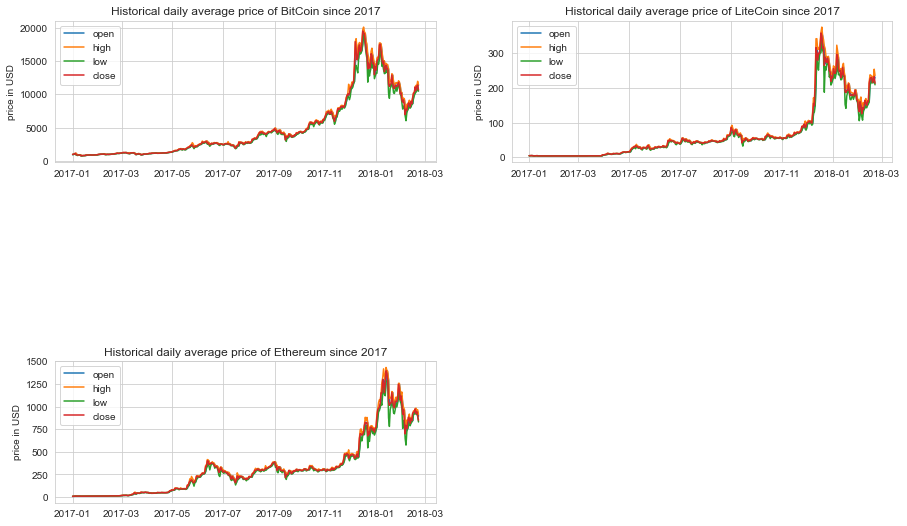

In [22]:
plt.figure(figsize=(15, 12))
plt.subplot(4,2,1)
plt.plot(bitcoin[['open','high','low','close']])
plt.ylabel('price in USD')
plt.title('Historical daily average price of BitCoin since 2017')
plt.legend(['open','high','low','close'])

plt.subplot(4,2,2)
plt.plot(litecoin[['open','high','low','close']])
plt.ylabel('price in USD')
plt.title('Historical daily average price of LiteCoin since 2017')
plt.legend(['open','high','low','close'])

plt.subplot(4,2,5)
plt.plot(ethereum[['open','high','low','close']])
plt.ylabel('price in USD')
plt.title('Historical daily average price of Ethereum since 2017')
plt.legend(['open','high','low','close'])

plt.show()

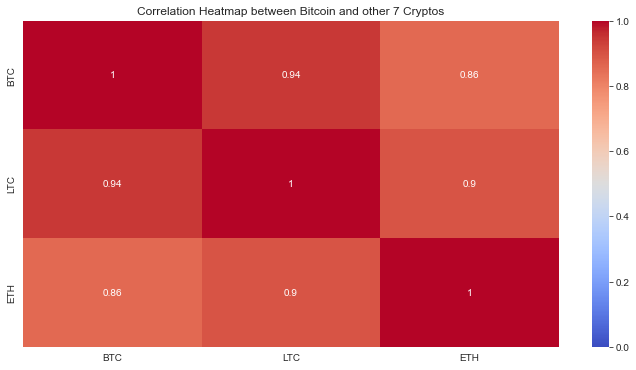

In [23]:
plt.figure(figsize=(12,6))
sns.heatmap(close.corr(),vmin=0, vmax=1, cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap between Bitcoin and other 7 Cryptos')
plt.show()

### Return Ratio<a id="3-5"></a>

return ratio = current value of the cryptocurrency / initial value of the cryptocurrency

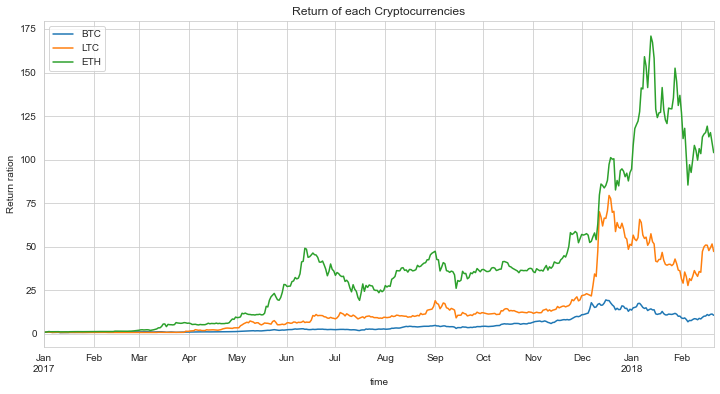

In [24]:
returns = close.apply(lambda x: x/x[0])
returns.plot(figsize=(12,6))
plt.ylabel('Return ration')
plt.xlabel('time')
plt.title('Return of each Cryptocurrencies')
plt.show()

## 4. Building Models to Predicting Price for Cryptocurrencies <a id="4"></a>

### Prepare Data for Models<a id="4-1"></a>

In [25]:
# droping 'slug' and 'name' as we can just use 'symbol', and droping 'ranknow'.
data=data.drop(['slug', 'name', 'ranknow'], axis=1)

# Bitcoin (BTC)
BTC = data[data.symbol == 'BTC'].copy()
BTC['daily_avg_After_Month']=BTC['daily_avg'].shift(-30)
X_BTC = BTC.dropna().drop(['daily_avg_After_Month','symbol','daily_avg'], axis=1)
y_BTC = BTC.dropna()['daily_avg_After_Month']
X_train_BTC, X_test_BTC, y_train_BTC, y_test_BTC = train_test_split(X_BTC, y_BTC, test_size=0.2, random_state=43)
X_forecast_BTC =  BTC.tail(30).drop(['daily_avg_After_Month','symbol','daily_avg'], axis=1)

# Ethereum (ETH)
ETH = data[data.symbol == 'ETH'].copy()
ETH['daily_avg_After_Month']=ETH['daily_avg'].shift(-30)
X_ETH = ETH.dropna().drop(['daily_avg_After_Month','symbol','daily_avg'], axis=1)
y_ETH = ETH.dropna()['daily_avg_After_Month']
X_train_ETH, X_test_ETH, y_train_ETH, y_test_ETH = train_test_split(X_ETH, y_ETH, test_size=0.2, random_state=43)
X_forecast_ETH =  ETH.tail(30).drop(['daily_avg_After_Month','symbol','daily_avg'], axis=1)

# Litecoin (LTC)
LTC = data[data.symbol == 'LTC'].copy()
LTC['daily_avg_After_Month']=LTC['daily_avg'].shift(-30)
X_LTC = LTC.dropna().drop(['daily_avg_After_Month','symbol','daily_avg'], axis=1)
y_LTC = LTC.dropna()['daily_avg_After_Month']
X_train_LTC, X_test_LTC, y_train_LTC, y_test_LTC = train_test_split(X_LTC, y_LTC, test_size=0.2, random_state=43)
X_forecast_LTC =  LTC.tail(30).drop(['daily_avg_After_Month','symbol','daily_avg'], axis=1)


### Applying Machine Learning Models<a id="4-2"></a>

In [26]:
# define regression function
def regression(X_train, X_test, y_train, y_test):
    Regressor = {
        'Random Forest Regressor': RandomForestRegressor(n_estimators=200),
        'Gradient Boosting Regressor': GradientBoostingRegressor(n_estimators=500),
        'ExtraTrees Regressor': ExtraTreesRegressor(n_estimators=500, min_samples_split=5),
        'Bayesian Ridge': BayesianRidge(),
        'Elastic Net CV': ElasticNetCV()
    }

    for name, clf in Regressor.items():
        print(name)
        clf.fit(X_train, y_train)
    
        print(f'R2: {r2_score(y_test, clf.predict(X_test)):.2f}')
        print(f'MAE: {mean_absolute_error(y_test, clf.predict(X_test)):.2f}')
        print(f'MSE: {mean_squared_error(y_test, clf.predict(X_test)):.2f}')
        print()

In [27]:
# Bitcoin (BTC)
print('Bitcoin (BTC):')
regression(X_train_BTC, X_test_BTC, y_train_BTC, y_test_BTC)

Bitcoin (BTC):
Random Forest Regressor
R2: 0.91
MAE: 816.73
MSE: 2065732.84

Gradient Boosting Regressor
R2: 0.91
MAE: 852.35
MSE: 2026191.85

ExtraTrees Regressor
R2: 0.93
MAE: 746.56
MSE: 1569674.04

Bayesian Ridge
R2: 0.67
MAE: 1622.02
MSE: 7817709.42

Elastic Net CV
R2: 0.61
MAE: 1857.99
MSE: 9186745.49



In [28]:
# Ethereum (ETH)
print('Ethereum (ETH):')
regression(X_train_ETH, X_test_ETH, y_train_ETH, y_test_ETH)

Ethereum (ETH):
Random Forest Regressor
R2: 0.89
MAE: 63.37
MSE: 9679.74

Gradient Boosting Regressor
R2: 0.89
MAE: 64.11
MSE: 10251.70

ExtraTrees Regressor
R2: 0.90
MAE: 59.12
MSE: 8964.92

Bayesian Ridge
R2: 0.61
MAE: 128.48
MSE: 34999.17

Elastic Net CV
R2: 0.65
MAE: 131.51
MSE: 31442.69



In [29]:
# Litecoin (LTC)
print('Litecoin (LTC):')
regression(X_train_LTC, X_test_LTC, y_train_LTC, y_test_LTC)

Litecoin (LTC):
Random Forest Regressor
R2: 0.74
MAE: 16.58
MSE: 1439.08

Gradient Boosting Regressor
R2: 0.63
MAE: 20.71
MSE: 2088.24

ExtraTrees Regressor
R2: 0.73
MAE: 17.39
MSE: 1526.53

Bayesian Ridge
R2: 0.40
MAE: 36.19
MSE: 3347.14

Elastic Net CV
R2: 0.41
MAE: 36.19
MSE: 3338.63



### Prices Prediction<a id="4-3"></a>

In [30]:
# define prediction function
def prediction(name, X, y, X_forecast):
    if name in ['XRP', 'LTC']:
        model = RandomForestRegressor(n_estimators=200)
    else:
        model = ExtraTreesRegressor(n_estimators=500, min_samples_split=5)
    model.fit(X, y)
    target = model.predict(X_forecast)
    return target

In [31]:
# calculate forecasted prices for next 30 days
forecasted_BTC = prediction('BTC', X_BTC, y_BTC, X_forecast_BTC)
forecasted_ETH = prediction('ETH', X_ETH, y_ETH, X_forecast_ETH)
forecasted_LTC = prediction('LTC', X_LTC, y_LTC, X_forecast_LTC)


In [32]:
# define index for next 30 days
last_date=data.iloc[-1].name
modified_date = last_date + dt.timedelta(days=1)
new_date = pd.date_range(modified_date,periods=30,freq='D')

# assign prediction to newly defined index
forecasted_BTC = pd.DataFrame(forecasted_BTC, columns=['daily_avg'], index=new_date)
forecasted_ETH = pd.DataFrame(forecasted_ETH, columns=['daily_avg'], index=new_date)
forecasted_LTC = pd.DataFrame(forecasted_LTC, columns=['daily_avg'], index=new_date)

# combine historical price and predicted price
bitcoin = pd.concat([data[data['symbol']=='BTC'][['daily_avg']], forecasted_BTC])
litecoin = pd.concat([data[data['symbol']=='LTC'][['daily_avg']], forecasted_LTC])

ethereum = pd.concat([data[data['symbol']=='ETH'][['daily_avg']], forecasted_ETH])


#### Bitcoin
Looking at the short-term forcasted trend in next month, the predicted price of Bitcoin is still volatile. Downward trending follows right after an increasing price trend, mainly because of the lacking of momentum. Investors need to be cautious with the drastic price flunctuation. Traders are advised to buy a **short-term put option** and **long-term call option**.

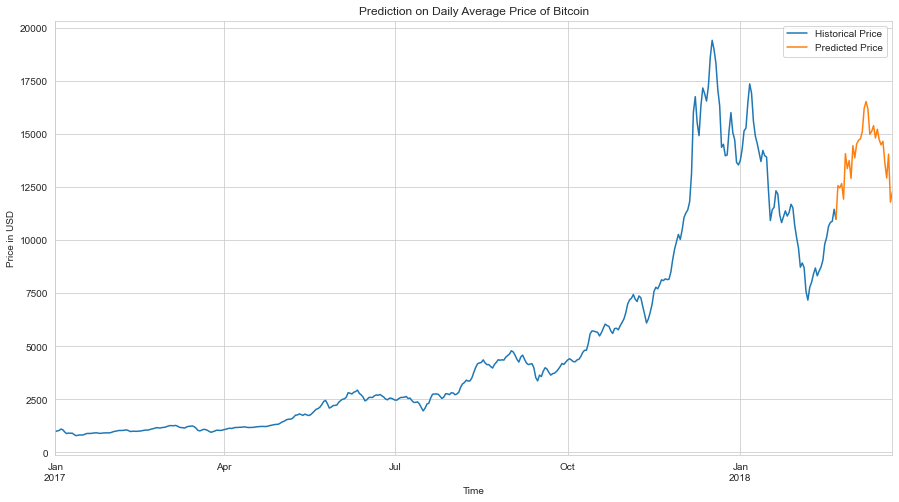

In [33]:
plt.figure(figsize=(15,8))
(bitcoin[:-30]['daily_avg']).plot(label='Historical Price')
(bitcoin[-31:]['daily_avg']).plot(label='Predicted Price')

plt.xlabel('Time')
plt.ylabel('Price in USD')
plt.title('Prediction on Daily Average Price of Bitcoin')
plt.legend()
plt.show()

#### Litcoin
The predicted price of Litcoin is still volatile. The lack in momentum is obvious in Litcoin's price. In the short term, Litcion holder is advertise to sell the coin in the near future, and traders are advised to buy a **short-term put option** and **long-term call option**.

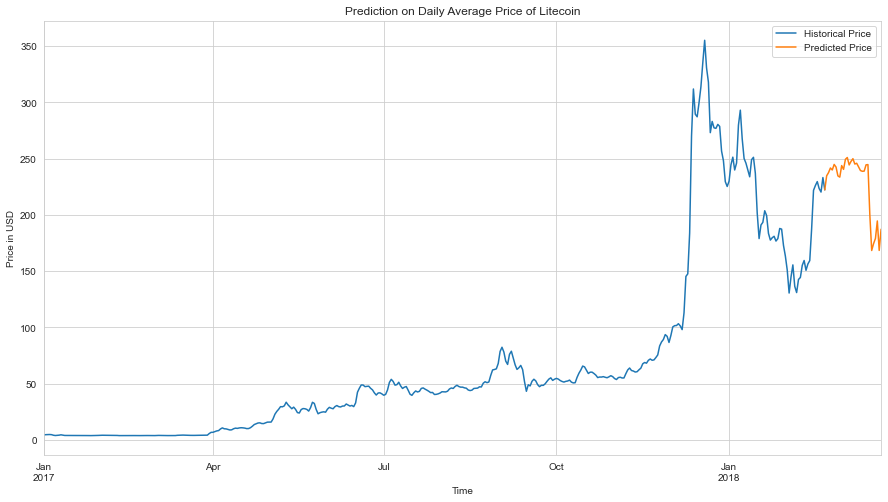

In [34]:
plt.figure(figsize=(15,8))
(litecoin[:-30]['daily_avg']).plot(label='Historical Price')
(litecoin[-31:]['daily_avg']).plot(label='Predicted Price')

plt.xlabel('Time')
plt.ylabel('Price in USD')
plt.title('Prediction on Daily Average Price of Litecoin')
plt.legend()
plt.show()

#### Ehereum
Similar to Bitcoin, the predicted price of Ehereum is volitle. Downward trending follows right after an increasing price trend, mainly because of the lacking of momentum. 

Investors need to be cautious with the drastic price flunctuation as the price has been gone very high. Traders are advised to buy a **short-term put option** and **long-term call option**.

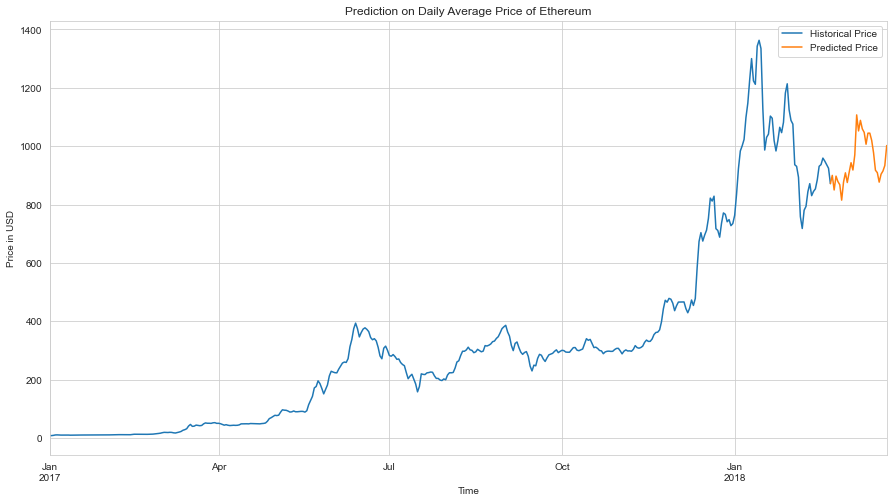

In [35]:
plt.figure(figsize=(15,8))
(ethereum[:-30]['daily_avg']).plot(label='Historical Price')
(ethereum[-31:]['daily_avg']).plot(label='Predicted Price')

plt.xlabel('Time')
plt.ylabel('Price in USD')
plt.title('Prediction on Daily Average Price of Ethereum')
plt.legend()
plt.show()